In [ ]:
#Mounting google and authenticating
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/ /mydrive
#!ls /mydrive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%ls /mydrive/music\ project

chopin_copy/  chpn-p24.wav  default_sound_font.sf2  guide.gdoc


In [ ]:
%cd /mydrive/music\ project 

/content/gdrive/My Drive/music project


In [ ]:
#copying and cd into same folder
%cp -av chopin/ chopin_copy

'chopin/' -> 'chopin_copy'
'chopin/chp_op18.mid' -> 'chopin_copy/chp_op18.mid'
'chopin/chp_op31.mid' -> 'chopin_copy/chp_op31.mid'
'chopin/chpn-p1.mid' -> 'chopin_copy/chpn-p1.mid'
'chopin/chpn-p10.mid' -> 'chopin_copy/chpn-p10.mid'
'chopin/chpn-p11.mid' -> 'chopin_copy/chpn-p11.mid'
'chopin/chpn-p12.mid' -> 'chopin_copy/chpn-p12.mid'
'chopin/chpn-p13.mid' -> 'chopin_copy/chpn-p13.mid'
'chopin/chpn-p15.mid' -> 'chopin_copy/chpn-p15.mid'
'chopin/chpn-p14.mid' -> 'chopin_copy/chpn-p14.mid'
'chopin/chpn-p16.mid' -> 'chopin_copy/chpn-p16.mid'
'chopin/chpn-p17.mid' -> 'chopin_copy/chpn-p17.mid'
'chopin/chpn-p18.mid' -> 'chopin_copy/chpn-p18.mid'
'chopin/chpn-p19.mid' -> 'chopin_copy/chpn-p19.mid'
'chopin/chpn-p2.mid' -> 'chopin_copy/chpn-p2.mid'
'chopin/chpn-p21.mid' -> 'chopin_copy/chpn-p21.mid'
'chopin/chpn-p20.mid' -> 'chopin_copy/chpn-p20.mid'
'chopin/chpn-p22.mid' -> 'chopin_copy/chpn-p22.mid'
'chopin/chpn-p23.mid' -> 'chopin_copy/chpn-p23.mid'
'chopin/chpn-p24.mid' -> 'chopin_copy/chp

In [ ]:
#!pwd
!pip install librosa

In [ ]:
#!pwd
!ls /mydrive/music\ project/chopin_copy

chpn_op10_e01.mid  chpn_op27_1.mid  chpn_op7_1.mid  chpn-p18.mid  chpn-p4.mid
chpn_op10_e05.mid  chpn_op27_2.mid  chpn_op7_2.mid  chpn-p19.mid  chpn-p5.mid
chpn_op10_e12.mid  chpn_op33_2.mid  chpn-p10.mid    chpn-p1.mid   chpn-p6.mid
chpn_op23.mid	   chpn_op33_4.mid  chpn-p11.mid    chpn-p20.mid  chpn-p7.mid
chpn_op25_e11.mid  chpn_op35_1.mid  chpn-p12.mid    chpn-p21.mid  chpn-p8.mid
chpn_op25_e12.mid  chpn_op35_2.mid  chpn-p13.mid    chpn-p22.mid  chpn-p9.mid
chpn_op25_e1.mid   chpn_op35_3.mid  chpn-p14.mid    chpn-p23.mid  chp_op18.mid
chpn_op25_e2.mid   chpn_op35_4.mid  chpn-p15.mid    chpn-p24.mid  chp_op31.mid
chpn_op25_e3.mid   chpn_op53.mid    chpn-p16.mid    chpn-p2.mid
chpn_op25_e4.mid   chpn_op66.mid    chpn-p17.mid    chpn-p3.mid


In [ ]:
!cp /mydrive/music\ project/chpn-p24.wav ./

In [ ]:
import librosa

In [ ]:
!pip install midi2audio
!pip install fluidsynth

  Created wheel for fluidsynth: filename=fluidsynth-0.2-cp37-none-any.whl size=4512 sha256=0d367c7d63265fdfee1f00aaf55bd394393cb286a4cb352bfb568815f1c04295
  Stored in directory: /root/.cache/pip/wheels/2d/70/4d/ffe2589bbfe9c268780570a6875583fbf59547004459e2c3c3
Successfully built fluidsynth


In [ ]:
!git clone https://github.com/bzamecnik/midi2audio
!pip install -e midi2audio

fatal: destination path 'midi2audio' already exists and is not an empty directory.
Obtaining file:///content/midi2audio
  Found existing installation: midi2audio 0.1.1
    Can't uninstall 'midi2audio'. No files were found to uninstall.
  Running setup.py develop for midi2audio


In [ ]:
!cp /mydrive/music\ project/default_sound_font.sf2 ~/fluidsynth/

In [ ]:
y, sr = librosa.load('/content/chpn-p24.wav')


In [ ]:
import numpy as np
spect = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=2048, hop_length=512)
spect = librosa.power_to_db(spect, ref=np.max)

(128, 5413) working


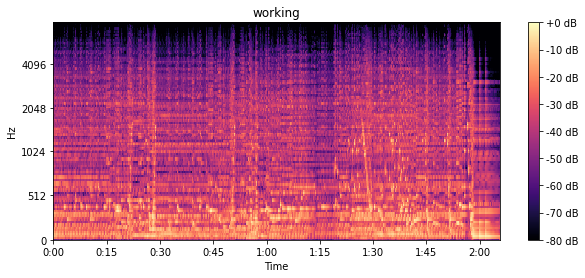

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

genre_name = 'working'
print(spect.shape, genre_name)
plt.figure(figsize=(10, 4))
librosa.display.specshow(spect, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title(str(genre_name))
plt.show()

In [ ]:
%pycat /content/midi2audio/midi2audio.py
!rm /content/midi2audio/midi2audio.py
%%writefile /content/midi2audio/midi2audio.py
###folowed by file